<center>
    
# Python For Quantum Mechanics
# Week 6: Tutorial
</center>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML


import numpy as np
import numpy.random as rnd

import scipy
from scipy import integrate

from numpy.fft import fftfreq
from scipy import fftpack

## Exercise 1: Solving The Schrodinger Equation Via Spectral Decomposition

We observed how to solve the Schrodinger equation using Scipy's integration functions. While still using the finite-difference approach, we can solve the Schrodinger equation via spectral decomposition.

We can rewrite the Schrodinger equation in Hamiltonian form:

$$i\hbar \frac{\partial |\psi(t)>}{\partial t} = \hat{H}|\psi(t)> $$

We can then solve for $|\psi(t)>$ as follows

$$|\psi(t)> = e^{-\frac{i\hat{H}t}{\hbar}}|\psi(0)> $$

Particulary if we are using a basis of Eigenstates $|E_\alpha>$ with eigenvalue $E_\alpha$,

$$\hat{H}|E_\alpha> = E_\alpha|E_\alpha> $$

This simplifies to 

$$|\psi(t)> = \sum_{\alpha=1}^{2^N}e^{-\frac{iE_\alpha t}{\hbar}}|E_\alpha> $$

Notice that the eigenstates only change by a phase with time, and therefore are stationary states. Their probability amplitude is constant as 

$$ \left(e^{-\frac{iE_\alpha t}{\hbar}}\right)^{\dagger}e^{-\frac{iE_\alpha t}{\hbar}}=1.0 $$


Similarly, a state in superposition of eigenstates is also a stationary state. It is only when we change basis, say from the eigenbasis to  a spatial basis, then the state changes in time. 

For an infinite, square potential well, define the Hamiltonian and plot it's first four eigenvectors

In [2]:
#Initialise discrete values of x
h = 0.005
x = np.arange(0, 1, h)
size = x.size

#Define the Laplace Operator
L = scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=(size, size)) / h**2

#Initialise the parameters and V
hbar = 1 
m = 1

V = np.zeros(shape=x.shape)
V[:] = 0.0
V[0] = 100000
V[-1] = 100000
Vmat = scipy.sparse.diags(V)

#Define the Hamiltonian
H = -1j*(-(hbar/(2*m))*L + (Vmat/hbar))

In [3]:
eigval, eigvec = scipy.linalg.eig(H.todense())

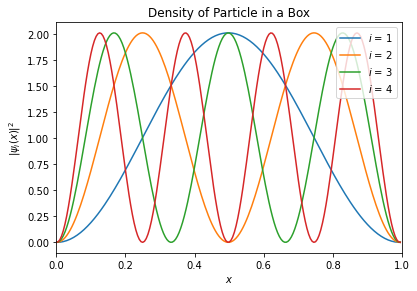

In [7]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,.8,.8])

#Plot the first four solutions
for i in range(1,5):
    density = abs(eigvec[:,i])**2
    norm_const = np.sum(density)*h
    norm_density = density / norm_const
    ax.plot(x, norm_density, label=r'$i$ = {}'.format(i)) 

ax.set_title('Density of Particle in a Box')
ax.set_xlim(0,1)
ax.set_xlabel('$x$')
ax.set_ylabel("$|\psi_i(x)|^2$")
ax.legend(loc='upper right')
plt.show()

## Exercise 2: Spin Systems & Spectral Decomposition

For a spin-$\frac{1}{2}$ XXZ Hamiltonian system:
$$\hat{H} = \sum_{j=1}^{N}J(\Delta(\sigma^x_j\sigma^x_{j+1} + \sigma^y_j\sigma^y_{j+1}) + \sigma^z_j\sigma^z_{j+1}) + \sum_{j=1}^{N}h\sigma^z_j  $$
where $\sigma_j$ are the Pauli matrices applies to the qubit/spin at position $j$. 
$$\sigma^x_j = \begin{bmatrix}0&1 \\1&0 \end{bmatrix}_j = \underbrace{\mathbb{1}}_{\text{1st position}} \otimes \mathbb{1} \otimes ... \otimes \underbrace{\sigma^x}_{\text{j-th position}}  \otimes \mathbb{1} \otimes ... \otimes \underbrace{\mathbb{1}}_{\text{Nth position}} $$

$$\sigma^y_j = \begin{bmatrix}0&-i \\i&0 \end{bmatrix}_j  = \underbrace{\mathbb{1}}_{\text{1st position}} \otimes \mathbb{1} \otimes ... \otimes \underbrace{\sigma^y}_{\text{j-th position}}  \otimes \mathbb{1} \otimes ... \otimes \underbrace{\mathbb{1}}_{\text{Nth position}} $$

$$\sigma^z_j = \begin{bmatrix}1&0 \\0&-1 \end{bmatrix}_j  = \underbrace{\mathbb{1}}_{\text{1st position}} \otimes \mathbb{1} \otimes ... \otimes \underbrace{\sigma^z}_{\text{j-th position}}  \otimes \mathbb{1} \otimes ... \otimes \underbrace{\mathbb{1}}_{\text{Nth position}}$$

The Pauli matrices above specifiy a particular basis, in which each spin-particle is in a superposition of spin-up $\begin{bmatrix}1\\0 \end{bmatrix}$ and spin-down $\begin{bmatrix}0\\1 \end{bmatrix}$, so 

$$|j> = \alpha_j|\uparrow>  + \beta_j|\downarrow> = \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix}$$

$$|\psi(0)> = \frac{1}{\sqrt{N}}\otimes_{j=1}^{N}|j> = \frac{1}{\sqrt{N}}\otimes_{j=1}^{N}(\alpha_j|\uparrow>  + \beta_j|\downarrow>) = \sum_{i=0}^{2^N}c_i|i>$$

$$\sum_{i=0}^{2^N}|c_i|^2 = 1 $$

Where 

$$|i=9>_{N=4} = |01001>$$
$$|i=32>_{N=5} = |100000>$$

Where $\frac{1}{\sqrt{N}}$ is a normalisation factor. Note that this is not necessairly the Eigenbasis.

Generate this Hamiltonian using Numpy and Scipy, for N = 10. It's dimension as a result of tensor multiplication will be $2^N$.

In [12]:
N = 10
D = 2**N
J = 1.0
delta = 1.0
h = 1.0

sigmax = np.array([[0,1],[1,0]],dtype='complex')
sigmay = np.array([[0,-1j],[1j,0]],dtype='complex')
sigmaz = np.array([[1,0],[0,-1]],dtype='complex')
Identity = np.eye(2,dtype='complex')

H = scipy.sparse.lil_matrix((D,D),dtype='complex')
SIGMAZ = scipy.sparse.lil_matrix((D,D),dtype='complex')

for j in range(1,N+1):
    if j==1:
        tempx=sigmax
        tempy=sigmay
        tempz=sigmaz
        tempz2 = sigmaz
    else:
        tempx=Identity
        tempy=Identity
        tempz=Identity
        tempz2=Identity
        
    for i in range(2,N+1):
        if i==j:
            tempx = scipy.sparse.kron(tempx,sigmax)
            tempy = scipy.sparse.kron(tempy,sigmay)
            tempz = scipy.sparse.kron(tempz,sigmaz)
            tempz2 = scipy.sparse.kron(tempz2,sigmaz)
        elif i==j+1:
            tempx = scipy.sparse.kron(tempx,sigmax)
            tempy = scipy.sparse.kron(tempy,sigmay)
            tempz = scipy.sparse.kron(tempz,Identity)
            tempz2 = scipy.sparse.kron(tempz2,sigmaz)
        else:
            tempx = scipy.sparse.kron(tempx,Identity)
            tempy = scipy.sparse.kron(tempy,Identity)
            tempz = scipy.sparse.kron(tempz,Identity)
            tempz2 = scipy.sparse.kron(tempz2,Identity)
    SIGMAZ = SIGMAZ + tempx
    H = H + J*(delta*(tempx + tempy) + tempz2) + h*tempz + 1*j*tempz2

print(H.todense()[0,0:])
print(H.shape)

[[75.+0.j  1.-1.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]
(1024, 1024)


Perform a spectral decomposition of this matrix, finding the matrix of Eigenvectors.

In [13]:
eigval, eigvec = scipy.linalg.eig(H.todense())

Generate a random, normalised, complex-valued initial state in an array of size $2^N$ which is interpreted to be in the basis $|i>$

$$|\psi(0)> = \sum_{i=0}^{2^N}c_i|i>$$

$$\sum_{i=0}^{2^N}|c_i|^2 = 1 $$

In [10]:
mu = 0
sigma = 1.0

psi0 = rnd.normal(mu,sigma,(D,1)) + rnd.normal(mu,sigma,(D,1))*1j
psi0 = psi0/np.sqrt(sum(abs(psi0)**2))

print(psi0.shape)

(1024, 1)


Suppose our initial state isn't exactly random, but we say for definite that the central spin-particle is in the state spin-up or $1$. This would make the coefficient of any basis-state with a $zero$ at the centre of the binary represention equal to $0$. 

Create a boolean array of size $2^N$ where $True$ values indicate the presence of a $0$ at the centre of the binary representation of the corresponding basis-state number. Use this boolean array to cast all corresponding elements in our initial state to zero. Renormalise the state afterwards.

In [14]:
psi0[:,0] = psi0[::-1,0]
print(psi0.shape)

bins = np.array([x for x in range(D)])

indices = np.array(psi0.shape,dtype='bool')
indices2 = np.array(psi0.shape,dtype='bool')
indices = (bins >> int(N/2))%2==1
indices2 = indices == 0

psi0[indices] = 0.0 + 0.0*1j
psi0 = psi0/np.sqrt(sum(abs(psi0)**2))

psi0[:,0] = psi0[::-1,0]

(1024, 1)


## Exercise 3: Discrete Quantum Walk

The quantum walk involves measuring the state of a quantum spin particle, and using the result to move left or right in a spatial dimension. If the spin is up, then move to the right one step. If the spin is down, move the spin to the left one step. We will do this for many time steps in this exercise and observe the resulting spatial distribution, starting with a spin up at in the centre of the one-dimensional space.

We must make use of the tensor product of Hilbert spaces, to account for the state of the spin and the spatial state. 

$$|spin> = \alpha|0> + \beta|1> $$

$$|\alpha|^2 + |\beta|^2 = 1 $$

$$|x> = \sum_{i=0}^{N-1}c_i|i> $$

$$ \sum_{i=0}^{N-1}|c_i|^2=1$$

The first operation performed at each time step is one to create superposition between spin up and down, or in other words applying a hadamard gate on the spin state. No operation is performed on the spatial state yet, so the N-dimensional identity matrix is applied in the tensor product.

$$ \mathbb{1}_N\otimes  \hat{H}$$

Create this matrix for N=100.

In [22]:
N=100


down = np.array([1,0])
up = np.array([0,1])

H = 1/np.sqrt(2)*scipy.linalg.hadamard(n=2)

HN = scipy.linalg.kron(np.eye(N),H)

The next operation to perform is a shift operation, which shifts the spatial state to the right by one step if the spin is down, and to the left by one step if the spin is up. It is written as follows

$$\hat{S} = \sum_i |i+1><i|\otimes |0><0| + \sum_i |i-1><i|\otimes |1><1| $$

First we must create matrix representations of $|0><0|$ and $|1><1|$, these are outer products of states 

$$|0> = \begin{bmatrix}1\\0\end{bmatrix}$$
$$|1> = \begin{bmatrix}0\\1\end{bmatrix}$$

Create these represenations using ```numpy.outer(a,b) ```

In [23]:
odown = np.outer(down,down)
print(odown)

oup = np.outer(up,up)
print(oup)

[[1 0]
 [0 0]]
[[0 0]
 [0 1]]


A problem arises at the boundaries of the system, $i=0$ and $i=99$. What happens when you shift these positions left and right respectively? We will implement periodic boundary conditions to simplify this problem. In other words, when shifting the last position to the right, it will move into the first position. When shifting the first position left, it will move to the last position. This shouldn't cause much of a physical problem if we make the system large enough. 

Create a matrix representations for the folowing operations

$$ \sum_{i=0}^{N-1} |i+1><i| $$

$$ \sum_{i=0}^{N-1} |i-1><i| $$

Hint: Use ```numpy.roll()```

In [24]:
ShiftForward = np.roll(np.eye(N), 1, axis=0)
ShiftBack = np.roll(np.eye(N), -1, axis=0)

Now, using tensor products, create a matrix representation of $\hat{S}$

In [25]:
S = scipy.linalg.kron(ShiftForward, odown) + scipy.linalg.kron(ShiftBack, oup)
print(S)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


Now the entire operation, for each time step, is encapsulated in the operation

$$\hat{U} = \hat{S}\times(\mathbb{1}_N\otimes  \hat{H} ) $$

Create the matrix representation of $\hat{U}$, also check if it is unitary.

In [27]:
U = S.dot(HN)
print(U,'\n')

TempU = np.matrix(U)
print(np.all(np.round(TempU*TempU.H) == np.eye(TempU.shape[0])))

[[ 0.          0.          0.         ...  0.          0.70710678
   0.70710678]
 [ 0.          0.          0.70710678 ...  0.          0.
   0.        ]
 [ 0.70710678  0.70710678  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.70710678
  -0.70710678]
 [ 0.          0.          0.         ...  0.70710678  0.
   0.        ]
 [ 0.70710678 -0.70710678  0.         ...  0.          0.
   0.        ]] 

True


We now have to create an initial state, namely a spin superposition at the central site. So

$$|\psi_0> =|\frac{N}{2}>\otimes \frac{1}{\sqrt{2}}(|0>+i|1>)$$

Create the initial state.

In [28]:
x = np.zeros(N)
x[int(N/2)] = 1


psi0 = np.kron(x,np.sqrt(1/2)*(down+1j*up))

To apply the operator $n$ times, multiply the initial state by $\hat{U}^n $ 

$$|\psi_n> = \hat{U}^n |\psi_0> $$

In [32]:
n = 50

psin = np.linalg.matrix_power(U,n).dot(psi0)

We can measure the probability amplitude at each site using the folowing operator

$$|k><k|\otimes \mathbb{1} $$

By applying this operator for each site $k$, we can find a probability distribution. Loop through each site, finding it's probability amplitude and store the result in an array of size $N$.

In [33]:
prob = np.zeros(N)
for k in range(N):
    pos = np.zeros(N)
    pos[k] = 1
    Measure = np.kron(np.outer(pos,pos),np.eye(2))
    amp = Measure.dot(psin)
    prob[k] = amp.dot(amp.conjugate()).real

Plot the resulting probability amplitude for each site.

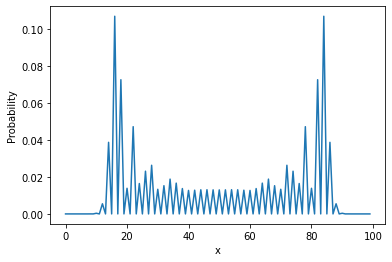

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(N), prob)
ax.set_xlabel('x')
ax.set_ylabel('Probability')

plt.show()

## Exercise 4: Heat Equation PDE

Solve the Heat equation, in two-dimensions, for the an initial condition $T(t=0,\textbf{x})$, where $\textbf{x}$ is some two-dimensional representation of a spatial coordinate.

The heat equation is given by

$$\frac{\partial{}}{\partial{t}}T(t,x,y) = \alpha \nabla T(t,x,y) $$
 
where

$$\nabla = \frac{\partial{}^2}{\partial{x^2}} + \frac{\partial{}^2}{\partial{y^2}} $$

and $\alpha$ is a constant. Animate the result as a heat map and surface plot. Here is the initial state:

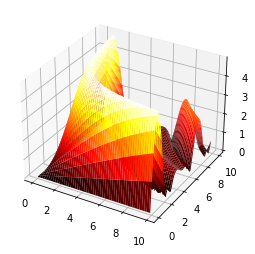

In [38]:
h = 0.1
x = np.arange(0,10,h)
y = np.arange(0,10,h)

Xmesh,Ymesh = np.meshgrid(x, y)
def T0(X,Y):
    w = 0.1
    return abs(np.sin(0.5*w*X*Y) + np.sin(0.75*w*X*Y) + np.sin(1.25*w*X*Y) + np.sin(1.5*w*X*Y) + np.sin(1.75*w*X*Y) + np.sin(2.25*w*X*Y))

T0_grid = T0(Xmesh,Ymesh)

fig = plt.figure()
ax1 = fig.add_axes([.1,.1,.8,.8],projection='3d')

ax1.plot_surface(Xmesh,Ymesh,T0_grid, cmap='hot')

plt.show()

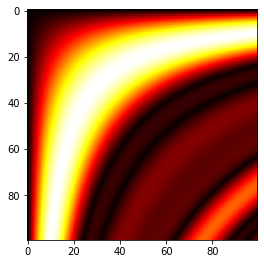

In [39]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,.8,.8])

ax.imshow(T0_grid, cmap = 'hot')

plt.show()

The first objective is to apply the Laplace operator in two-dimensions at each point, via the finite difference method. 

In [40]:
L = scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=T0_grid.shape)/h**2
alpha = 1.0

def int_fun(t,T_flat):
    T_grid = T_flat.reshape(T0_grid.shape)
    return (alpha*(L.dot(T_grid)+L.dot(T_grid.T).T)).flatten()

dt=0.1
t0=0.0
tf=10.0
t_eval = np.arange(t0, tf, dt)

sol = integrate.solve_ivp(int_fun, t_span = [t0, tf], y0 = T0_grid.flatten(), t_eval = t_eval)

<IPython.core.display.Javascript object>


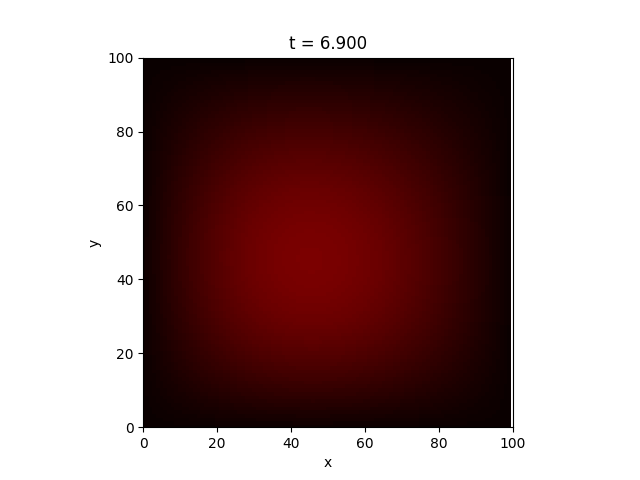

In [41]:
%matplotlib notebook

fig = plt.figure()
ax1 = plt.subplot(1,1,1)

ax1.set_xlim(0, x.size)
ax1.set_ylim(0, y.size)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

title = ax1.set_title('The Quantum Harmonic Osciallator')

line1, = ax1.plot([], [], ls = "--")

im = ax1.imshow(sol.y[:,0].reshape(T0_grid.shape), cmap='hot')


def init():
    im.set_array(sol.y[:,0].reshape(T0_grid.shape))
    return im,


def animate(i):
    a=im.get_array()
    a=sol.y[:,i].reshape(T0_grid.shape)  
    #a = a + dt*alpha*(L.dot(a)+L.dot(a.T).T)
    im.set_array(a)
    title.set_text('t = {0:1.3f}'.format(sol.t[i]))
    return im,


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=50, blit=True)

plt.show()

## Exercise 5: Particle In A Two-Dimensional Potential Well

Using similar methods as in exercise 3, solve the Schrodinger equation for the following initial state ```psi0``` and potential well. Animate the result.

<IPython.core.display.Javascript object>


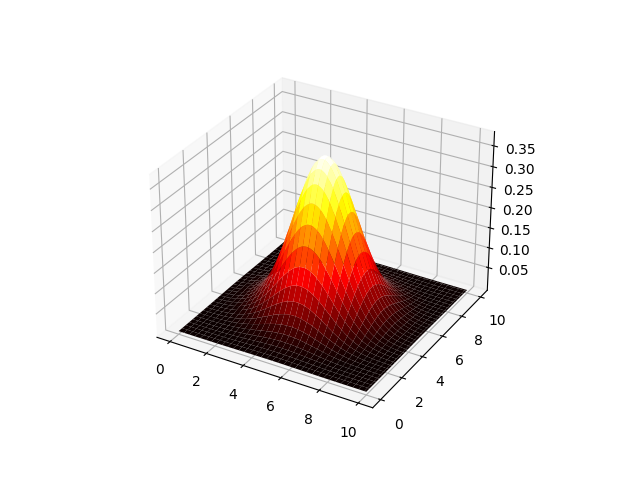

In [42]:
h = 0.1
x = np.arange(0,10+h,h)
y = np.arange(0,10+h,h)

Xmesh,Ymesh = np.meshgrid(x, y)
psi0_grid = np.array(Xmesh.shape,dtype='complex')
def psi0(X,Y):
    f = 10*8*(2*np.pi)
    sigma = 1.5 
    x0 = 5
    return (1.0/np.sqrt(sigma*np.sqrt(np.pi)))*np.exp(-((Xmesh-x0)**2+(Ymesh-x0)**2)/(2.0*sigma**2))*np.exp(1j*f*(Xmesh+Ymesh))+0*1j

psi0_grid = psi0(Xmesh,Ymesh)
norm_const = sum((abs(psi0_grid.flatten()))**2)*(h**2)
psi0_grid = psi0_grid/np.sqrt(norm_const)


fig = plt.figure()
ax1 = fig.add_axes([.1,.1,.8,.8],projection='3d')

ax1.plot_surface(Xmesh,Ymesh,psi0_grid.real, cmap='hot')

plt.show()

<IPython.core.display.Javascript object>


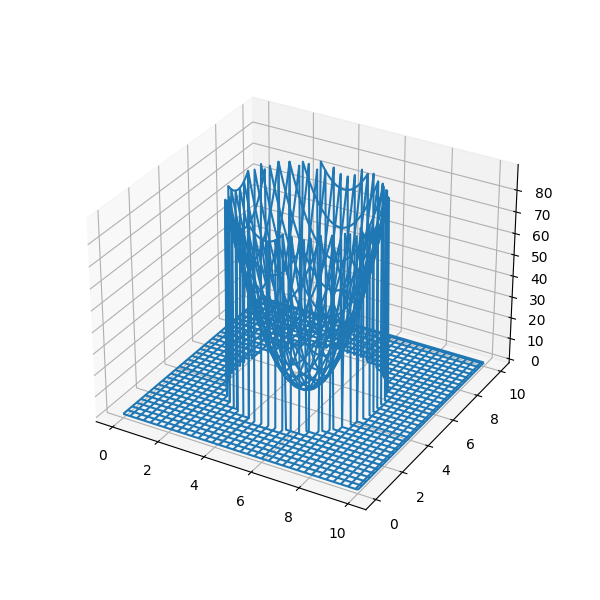

In [43]:
R = 5
r =3

V = np.zeros(psi0_grid.shape)
indices = np.sqrt((Xmesh-R)**2 + (Ymesh-R)**2)<r
V[indices] = 10*((Xmesh[indices]-R)**2 + (Ymesh[indices]-R)**2)


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_axes([.1,.1,.8,.8],projection='3d')

ax1.plot_wireframe(Xmesh,Ymesh,V, cmap='hot')

plt.show()

In [44]:
L = scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=psi0_grid.shape)/h**2

hbar=1
m=1



def wave_fun(t, psi_flat):
    psi_grid = psi_flat.reshape(psi0_grid.shape)
    return (-1j*(-(hbar/(2*m))*(L.dot(psi_grid)+L.dot(psi_grid.T).T) + (V/hbar)*(psi_grid))).flatten()

dt=0.01
t0=0.0
tf=2.0
t_eval = np.arange(t0, tf, dt)

sol = integrate.solve_ivp(wave_fun, t_span = [t0, tf], y0 = psi0_grid.flatten(), t_eval = t_eval)

In [45]:
#Renormalise the wave functions

for i in range(sol.y.shape[1]):
    norm_const = sum((abs(sol.y[:,i]))**2)*(h**2)
    sol.y[:,i] = sol.y[:,i]/np.sqrt(norm_const)

In [27]:
np.min(sol.y.real )

-2.3361213997035173

<IPython.core.display.Javascript object>


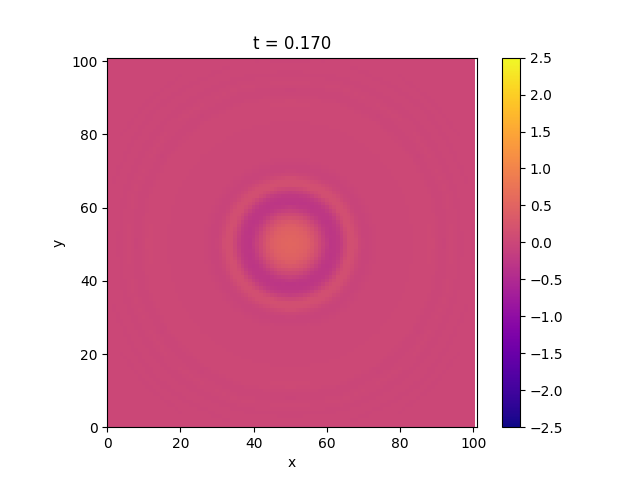

In [47]:
%matplotlib notebook

fig = plt.figure()
ax1 = plt.subplot(1,1,1)

ax1.set_xlim(0, x.size)
ax1.set_ylim(0, y.size)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

title = ax1.set_title('The Quantum Harmonic Osciallator')

line1, = ax1.plot([], [], "--")

im = ax1.imshow(sol.y[:,0].reshape(psi0_grid.shape).real ,cmap='plasma')
im.set_clim(vmin=-2.5, vmax=2.5)
fig.colorbar(im, ax=ax1, ticks=np.arange(-2.5,3,.5))


def init():
    im.set_array(sol.y[:,0].reshape(psi0_grid.shape).real )
    return [im]


def animate(i):
    a=im.get_array()
    a=sol.y[:,i].reshape(psi0_grid.shape).real  
    #a = a + dt*alpha*(L.dot(a)+L.dot(a.T).T)
    im.set_array(a)
    title.set_text('t = {0:1.3f}'.format(sol.t[i]))
    return [im]


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=50, blit=True)

plt.show()

#fn = 'QuantumWell'
#anim.save(fn+'.mp4',writer='ffmpeg',fps=fps)

<IPython.core.display.Javascript object>


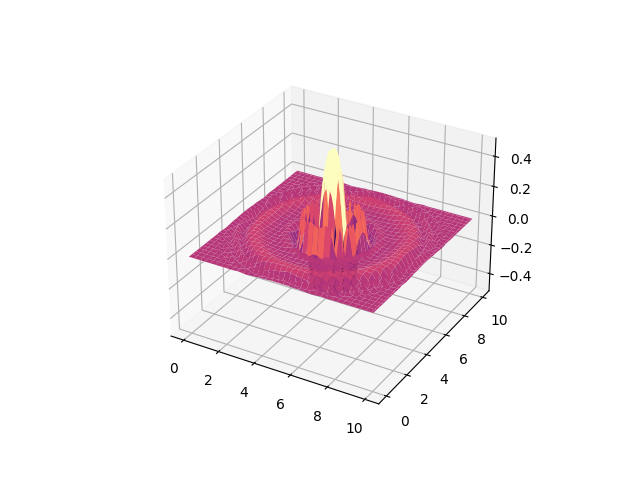

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  
ax.set_zlim(-.5,.5)


plot = [ax.plot_surface(Xmesh, Ymesh, sol.y[:,0].reshape(psi0_grid.shape).real, cmap="magma")]

plot[0].set_clim(vmin=-.25, vmax=.25)


def animate(i, sol, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(Xmesh, Ymesh, sol.y[:,i].reshape(psi0_grid.shape).real, cmap="magma")
    plot[0].set_clim(vmin=-.25, vmax=.25)
    

anim = animation.FuncAnimation(fig, animate, frames=len(sol.t), fargs=(sol, plot),interval=10, blit=True)


plt.show()

<IPython.core.display.Javascript object>


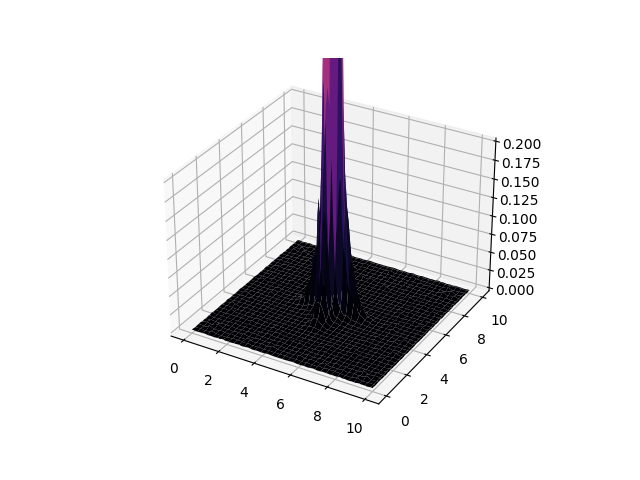

In [49]:
def animate(i, sol, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(Xmesh, Ymesh, abs(sol.y[:,i].reshape(psi0_grid.shape))**2, cmap="magma")

    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')   
ax.set_zlim(0,.2)
plot = [ax.plot_surface(Xmesh, Ymesh, abs(sol.y[:,0].reshape(psi0_grid.shape))**2, cmap="magma")]

anim = animation.FuncAnimation(fig, animate, frames=len(sol.t), fargs=(sol, plot),interval=50, blit=True)


plt.show()

### Hydrogen Potential

<IPython.core.display.Javascript object>


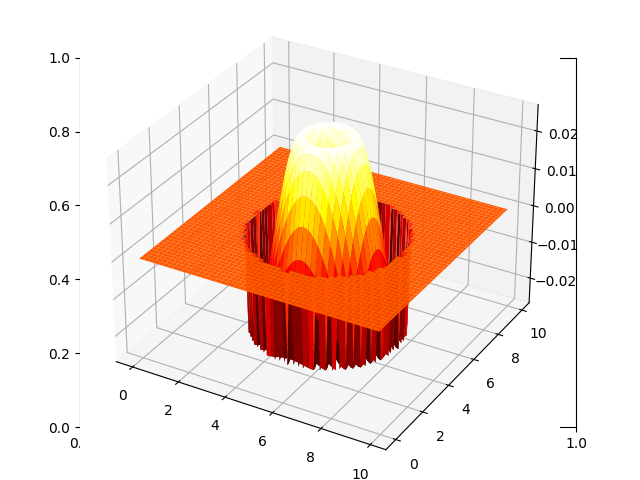

In [50]:
h = 0.1
x = np.arange(0,10,h)
y = np.arange(0,10,h)

Xmesh,Ymesh = np.meshgrid(x, y)
psi0_grid = np.array(Xmesh.shape,dtype='complex')
def psi0(X,Y):
    f = 100*(2*np.pi)
    sigma = 1.5 
    x0 = 5
    #return (1.0/np.sqrt(sigma*np.sqrt(np.pi)))*np.exp(-((Xmesh-x0)**2+(Ymesh-x0-3)**2)/(2.0*sigma**2))*np.exp(1j*f*(Xmesh+Ymesh)) + 0*1j
    return np.sin(np.sqrt((Xmesh-x0)**2 + (Ymesh-x0)**2)*5*np.pi/x[-1]) + 0*1j

x0 = 5
indices = np.sqrt((Xmesh-x0)**2 + (Ymesh-x0)**2)>3

psi0_grid = psi0(Xmesh,Ymesh) 
psi0_grid[indices] = 0.0
psi0_grid = psi0_grid/(np.sqrt(sum((abs(psi0_grid.flatten()))**2)))


fig = plt.figure()
ax1 =  plt.subplot(111)

ax1 = fig.add_axes([0,0,1,1],projection='3d')
ax1.plot_surface(Xmesh,Ymesh,psi0_grid.real, cmap='hot')

plt.show()

<IPython.core.display.Javascript object>


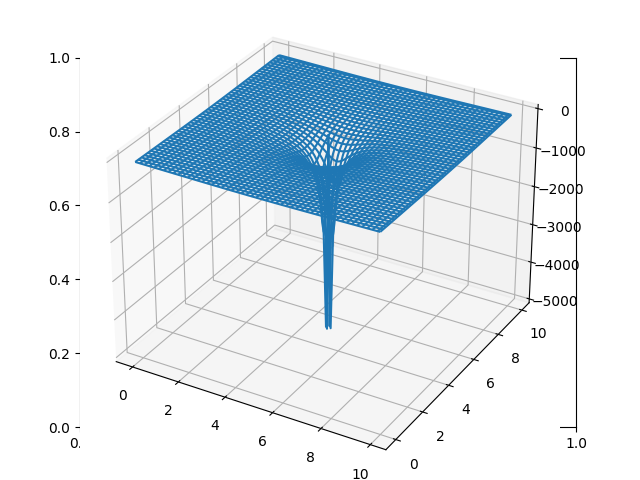

In [51]:
k=500
R=5

V = np.sqrt((Xmesh-R)**2 + (Ymesh-R)**2)

indices = V==0
V[indices]=-5000
V = -k/V

fig = plt.figure()
ax1 =  plt.subplot(111)

ax1 = fig.add_axes([0,0,1,1],projection='3d')
ax1.plot_wireframe(Xmesh,Ymesh,V, cmap='hot')

plt.show()

In [52]:
L = scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=psi0_grid.shape)/h**2

hbar=1
m=1



def wave_fun(t, psi_flat):
    psi_grid = psi_flat.reshape(psi0_grid.shape)
    return (-1j*(-(hbar/(2*m))*(L.dot(psi_grid)+L.dot(psi_grid.T).T) + (V/hbar)*(psi_grid))).flatten()

dt=0.01
t0=0.0
tf=2.0
t_eval = np.arange(t0, tf, dt)

sol = integrate.solve_ivp(wave_fun, t_span = [t0, tf], y0 = psi0_grid.flatten(), t_eval = t_eval)

<IPython.core.display.Javascript object>


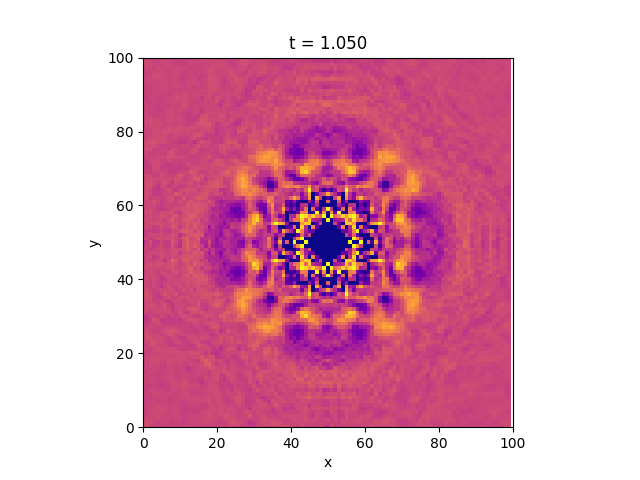

In [53]:
%matplotlib notebook

fig = plt.figure()
ax1 = plt.subplot(1,1,1)

ax1.set_xlim(0, x.size)
ax1.set_ylim(0, y.size)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

title = ax1.set_title('The Quantum Harmonic Osciallator')

line1, = ax1.plot([], [], "--")

im = ax1.imshow(sol.y[:,0].reshape(psi0_grid.shape).real ,cmap='plasma')


def init():
    im.set_array(sol.y[:,0].reshape(psi0_grid.shape).real )
    return [im]


def animate(i):
    a=im.get_array()
    a=sol.y[:,i].reshape(psi0_grid.shape).real  
    #a = a + dt*alpha*(L.dot(a)+L.dot(a.T).T)
    im.set_array(a)
    title.set_text('t = {0:1.3f}'.format(sol.t[i]))
    return [im]


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=50, blit=True)

plt.show()

#fn = 'QuantumWell'
#anim.save(fn+'.mp4',writer='ffmpeg',fps=fps)